In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 5.1MB/s 


In [0]:
import pandas as pd
link_hilstrom = 'https://drive.google.com/open?id=15osyN4c5z1pSo1JkxwL_N8bZTksRvQuU'
fluff, id = link_hilstrom.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Hillstrom.csv')
hillstrom_df = pd.read_csv('Hillstrom.csv')

In [0]:
import pandas as pd
link_lalonde = 'https://drive.google.com/open?id=1b8N7WtwIe2WmQJD1KL5UAy70K13MxwKj'
fluff, id = link_lalonde.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Lalonde.csv')
lalonde_df = pd.read_csv('Lalonde.csv')

In [0]:
link_criteo_fix = 'https://drive.google.com/open?id=13pNFAeH1ZEPxaCU9tQz1H17L28aTcppg'
fluff, id = link_criteo_fix.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('criteo_small_fix.csv')
criteo_df = pd.read_csv('criteo_small_fix.csv')

In [0]:
import csv
import json
import os
from os.path import isfile, join
from sklearn.model_selection import KFold, StratifiedKFold


def preprocess_data(df, dataset='hillstrom', verbose=True):
    # For Hillstrom dataset, the ‘‘visit’’ target variable was selected
    #   as the target variable of interest and the selected treatment is 
    #   the e-mail campaign for women’s merchandise [1]
    # [1] Kane K, Lo VSY, Zheng J. True-lift modeling: Comparison of methods. 
    #    J Market Anal. 2014;2:218–238
    dataset = dataset.lower()
    if dataset in ('hillstrom', 'email'):
        columns = df.columns
        for col in columns:
            if df[col].dtype != object:
                continue
            df = pd.concat(
                    [df, pd.get_dummies(df[col], 
                                        prefix=col, 
                                        drop_first=False)],
                    axis=1)
            df.drop([col], axis=1, inplace=True)

        df.columns = [col.replace('-', '').replace(' ', '_').lower()
                      for col in df.columns]
        df = df[df.segment_mens_email == 0]
        df.index = range(len(df))
        df.drop(['segment_mens_email', 
                 'segment_no_email', 
                 'conversion', 
                 'spend'], axis=1, inplace=True)

        y_name = 'visit'
        t_name = 'segment_womens_email'
    elif dataset in ['criteo', 'ad']:
        df = df.fillna(0)
        
        y_name = 'y'
        t_name = 'treatment'
    elif dataset == 'lalonde':
        y_name = 'RE78'
        t_name = 'treatment'
    else:
        raise NotImplementedError
    
    df['Y'] = df[y_name]
    df.drop([y_name], axis=1, inplace=True)
    df['T'] = df[t_name]
    df.drop([t_name], axis=1, inplace=True)
    
    return df

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def performance(pr_y1_t1, pr_y1_t0, y, t, groups=10):
    """
    1. Split the total customers into the given number of groups
    2. Calculate the statistics of each segment
    
    Args:
        pr_y1_t1: the series (list) of the customer's expected return
        pr_y1_t0: the expected return when a customer is not treated
        y: the observed return of customers
        t: whther each customer is treated or not
        groups: the number of groups (segments). Should be 5, 10, or 20
    Return:
        DataFrame:
            columns:
                'n_y1_t1': the number of treated responders
                'n_y1_t0': the number of not treated responders
                'r_y1_t1': the average return of treated customers
                'r_y1_t0': the average return of not treated customers
                'n_t1': the number of treated customers
                'n_t0': the number of not treated customers
                'uplift': the average uplift (the average treatment effect)
            rows: the index of groups
    """
  
    ### check valid arguments
    if groups not in [5, 10, 20]:
        raise Exception("uplift: groups must be either 5, 10 or 20")
  
    ### check for NAs.
    if pr_y1_t1.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_t1")
    if pr_y1_t0.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_t0")
    if y.isnull().values.any():
        raise Exception("uplift: NA not permitted in y")
    if t.isnull().values.any():
        raise Exception("uplift: NA not permitted in t")
   
    ### check valid values for y and t
    # if set(y) != {0, 1}:
    #     raise Exception("uplift: y must be either 0 or 1")
    if set(t) != {0, 1}:
        raise Exception("uplift: t must be either 0 or 1")

    ### check length of arguments
    if not (len(pr_y1_t1) == len(pr_y1_t0) == len(y) == len(t)):
        raise Exception("uplift: arguments pr_y1_t1, pr_y1_t0, y and t must all have the same length")

    ### define dif_pred
    dif_pred = pr_y1_t1 - pr_y1_t0
  
    ### Make index same
    y.index = dif_pred.index
    t.index = dif_pred.index
    
    mm = pd.DataFrame({
        'dif_pred': dif_pred,
        'y': y,
        't': t,
        'dif_pred_r': dif_pred.rank(ascending=False, method='first')
    })

    mm_groupby = mm.groupby(pd.qcut(mm['dif_pred_r'], groups, labels=range(1, groups+1), duplicates='drop'))
  
    n_y1_t1 = mm_groupby.apply(lambda r: r[r['t'] == 1]['y'].sum())
    n_y1_t0 = mm_groupby.apply(lambda r: r[r['t'] == 0]['y'].sum())
    n_t1 = mm_groupby['t'].sum()
    n_t0 = mm_groupby['t'].count() - n_t1
  
    df = pd.DataFrame({
        'n_t1': n_t1,
        'n_t0': n_t0,
        'n_y1_t1': n_y1_t1,
        'n_y1_t0': n_y1_t0,
        'r_y1_t1': n_y1_t1 / n_t1,
        'r_y1_t0': n_y1_t0 / n_t0,
    })
    fillna_columns = ['n_y1_t1', 'n_y1_t0', 'n_t1', 'n_t0']
    df[fillna_columns] = df[fillna_columns].fillna(0)
    df.index.name = 'groups'

    df['uplift'] = df['r_y1_t1'] - df['r_y1_t0']
    df['uplift'] = round(df['uplift'], 6)

    return df


def qini(perf, plotit=True):
    nrow = len(perf)

    # Calculating the incremental gains. 
    # - First, the cumulitative sum of the treated and the control groups are
    #  calculated with respect to the total population in each group at the
    #  specified decile
    # - Afterwards we calculate the percentage of the total amount of people
    #  (both treatment and control) are present in each decile
    cumul_y1_t1 = (perf['n_y1_t1'].cumsum() / perf['n_t1'].cumsum()).fillna(0)
    cumul_y1_t0 = (perf['n_y1_t0'].cumsum() / perf['n_t0'].cumsum()).fillna(0)
    deciles = [i/nrow for i in range(1, nrow+1)]

    ### Model Incremental gains
    inc_gains = (cumul_y1_t1 - cumul_y1_t0) * deciles
    inc_gains = [0.0] + list(inc_gains)

    ### Overall incremental gains
    overall_inc_gain = sum(perf['n_y1_t1']) / sum(perf['n_t1']) \
            - sum(perf['n_y1_t0']) / sum(perf['n_t0'])

    ### Random incremental gains
    random_inc_gains = [i*overall_inc_gain / nrow for i in range(nrow+1)]

    ### Compute area under the model incremental gains (uplift) curve
    x = [0] + deciles
    y = list(inc_gains)
    auuc = 0
    auuc_rand = 0

    auuc_list = [auuc]
    for i in range(1, len(x)):
        auuc += 0.5 * (x[i] - x[i-1]) * (y[i] + y[i-1])
        auuc_list.append(auuc)

    ### Compute area under the random incremental gains curve
    y_rand = random_inc_gains

    auuc_rand_list = [auuc_rand]
    for i in range(1, len(x)):
        auuc_rand += 0.5 * (x[i] - x[i-1]) * (y_rand[i] + y_rand[i-1])
        auuc_rand_list.append(auuc_rand)

    ### Compute the difference between the areas (Qini coefficient)
    Qini = auuc - auuc_rand

    ### Plot incremental gains curve
    if plotit:
        x_axis = x
        plt.plot(x_axis, inc_gains)
        plt.plot(x_axis, random_inc_gains)
        plt.show()
    
    ### Qini 30%, Qini 10%
    n_30p = int(nrow*3/10)
    n_10p = int(nrow/10)
    qini_30p = auuc_list[n_30p] - auuc_rand_list[n_30p]
    qini_10p = auuc_list[n_10p] - auuc_rand_list[n_10p]

    res = {
        'qini': Qini,
        'inc_gains': inc_gains,
        'random_inc_gains': random_inc_gains,
        'auuc_list': auuc_list,
        'auuc_rand_list': auuc_rand_list,
        'qini_30p': qini_30p,
        'qini_10p': qini_10p,
    }    

    return res


In [0]:
import itertools
import numpy as np

def parameter_tuning(fit_mdl, pred_mdl, data, search_space, plotit=False):
    """
    Given a model, search all combination of parameter sets and find
    the best parameter set
    
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "t_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "t_test": treatment variables of test (usually, validation) dataset,
            }
        search_space:
            {
                parameter_name: [search values]
            }
    Return:
        The best parameter set
    """
    x_train = data['x_train']
    y_train = data['y_train']
    t_train = data['t_train']
    x_test = data['x_test']
    y_test = data['y_test']
    t_test = data['t_test']
    
    max_q = -float('inf')
    best_mdl = None

    keys = search_space.keys()
    n_space = [len(search_space[key]) for key in keys]
    n_iter = np.prod(n_space)
    
    best_params = None
    for i in range(n_iter):
        params = {}
        for idx, key in enumerate(keys):
            params[key] = search_space[key][i % n_space[idx]]
            i = int(i / n_space[idx])

        mdl = fit_mdl(x_train, y_train, t_train, **params)
        pred = pred_mdl(mdl, newdata=x_test, y=y_test, t=t_test, ct=t_test)
        # print('    {}'.format(params))
        try:
            perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], y_test, t_test)
        except Exception as e:
            print(e)
            continue
        q = qini(perf, plotit=plotit)['qini']
        if plotit:
            print(q, params)
        if q > max_q:
            max_q = q
            best_mdl = mdl
            best_params = params

    return best_mdl, best_params


def wrapper(fit_mdl, pred_mdl, data, params=None,
            best_models=None, drop_variables=None, qini_values=None, wrapper_variables=None):
    """
    General wrapper approach
    
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "t_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "t_test": treatment variables of test (usually, validation) dataset,
            }
    Return:
        (A list of best models, The list of dropped variables)
    """
    if best_models is None:
        best_models = []
    if drop_variables is None:
        drop_variables = []
    if qini_values is None:
        qini_values = []
    if params is None:
        params = {}

    x_train = data['x_train']
    y_train = data['y_train']
    t_train = data['t_train']
    x_test = data['x_test']
    y_test = data['y_test']
    t_test = data['t_test']

    variables = data['x_train'].columns

    max_q = -float('inf')
    drop_var = None
    best_mdl = None
    for var in variables:
        if var in drop_variables:
            continue
        x = x_train.copy()
        x.drop(drop_variables + [var], axis=1, inplace=True)
        mdl = fit_mdl(x, y_train, t_train, **params)
        x = x_test.copy()
        x.drop(drop_variables + [var], axis=1, inplace=True)
        pred = pred_mdl(mdl, newdata=x, y=y_test, t=t_test, ct=t_test)
        perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], y_test, t_test)
        q = qini(perf, plotit=False)['qini']
        if q > max_q:
            max_q = q
            drop_var = var
            best_mdl = mdl
    
#         previous_max = wrapper_variables.loc[len(drop_variables) + 1, fit_mdl.__name__]
#         if q > previous_max:
#             wrapper_variables.loc[len(drop_variables) + 1, fit_mdl.__name__] = q
    
    
    best_models.append(best_mdl)
    drop_variables.append(drop_var)
    qini_values.append(max_q)

    left_vars = [var for var in variables if (var not in drop_variables)]
    
    if len(variables) == len(drop_variables) + 1:
        return best_models, drop_variables + left_vars, qini_values
    else:
        return wrapper(fit_mdl, pred_mdl, data, params=params,
                       best_models=best_models, drop_variables=drop_variables,
                       qini_values=qini_values, wrapper_variables=wrapper_variables)



In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


def tma(x, y, t, method=LogisticRegression, **kwargs):
    """Training a model according to the "Two Model Approach" 
    (a.k.a. "Separate Model Approach")
    The default model is General Linear Model (GLM)
    
    Source: "Incremental Value Modeling" (Hansotia, 2002)

    Args:
        x: A data frame of predictors.
        y: A binary response (numeric) vector.
        t: A binary response (numeric) representing the treatment assignment
            (coded as 0/1).
        method: A sklearn model specifying which classification or regression
            model to use. This should be a method that can handle a 
            multinominal class variable.

    Return:
        Dictionary: A dictionary of two models. One for the treatment group, 
            one for the control group.

            {
                'model_treat': a model for the treatment group,
                'model_control': a model for the control group
            }

    """
    
    treat_rows = (t == 1)
    control_rows = (t == 0)
    model_treat = method(**kwargs).fit(x[treat_rows], y[treat_rows])
    model_control = method(**kwargs).fit(x[control_rows], y[control_rows])
    
    res = {
        'model_treat': model_treat,
        'model_control': model_control,
    }
    return res


def predict_tma(obj, newdata, **kwargs):
    """Predictions according to the "Two Model Approach" 
    (a.k.a. "Separate Model Approach")
    
    For each instance in newdata two predictions are made:
    1) What is the probability of a person responding when treated?
    2) What is the probability of a person responding when not treated
      (i.e. part of control group)?

    Source: "Incremental Value Modeling" (Hansotia, 2002)

    Args:
        obj: A dictionary of two models. 
            One for the treatment group, one for the control group.
        newdata: A data frame containing the values at which predictions
            are required.
    
    Return:
        DataFrame: A dataframe with predicted returns for when the customers
            are treated and for when they are not treated.
    """
   
    if isinstance(obj['model_treat'], LinearRegression):
        pred_treat = obj['model_treat'].predict(newdata)
    else:
        pred_treat = obj['model_treat'].predict_proba(newdata)[:, 1]

    if isinstance(obj['model_control'], LinearRegression):
        pred_control = obj['model_control'].predict(newdata)
    else:
        pred_control = obj['model_control'].predict_proba(newdata)[:, 1]
    
    # pred_treat = obj['model_treat'].predict(newdata)
    # pred_control = obj['model_control'].predict(newdata)
    pred_df = pd.DataFrame({
        "pr_y1_t1": pred_treat,
        "pr_y1_t0": pred_control,
    })
    return pred_df



In [0]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [0]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

def ty_assign(y, t):
    if y == 1 and t == 1:
        return "TR"
    elif y == 0 and t == 1:
        return "TN"
    elif y == 1 and t == 0:
        return "CR"
    elif y == 0 and t == 0:
        return "CN"
    else:
        return None


def t_assign(ty):
    if ty in ("TR", "TN"):
        return 1
    elif ty in ("CR", "CN"):
        return 0
    else:
        return None


def y_assign(ty):
    if ty in ("TR", "CR"):
        return 1
    elif ty in ("TN", "CN"):
        return 0
    else:
        return None

search_space = {
    'method': [LogisticRegression],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'penalty': ['none', 'l2'],
    'tol': [1e-2, 1e-3, 1e-4],
    'C': [1e6, 1e3, 1, 1e-3, 1e-6],
}

qini_resultset = {}
def main():
    ### Load data ###
#     datasets = [hillstrom_df, lalonde_df, criteo_df]
    datasets = [criteo_df]
#     dataset_type = ['hillstrom', 'lalonde', 'criteo']
    dataset_type = ['criteo']
    target_models = {
        'dta': [(dta, predict_dta)],
        'tma': [(tma, predict_tma)],
        'trans': [(lai, predict_lai), (glai, predict_glai), (rvtu, predict_rvtu)],
        'tree': [(uplift_tree, predict_tree), (upliftRF, predict_upliftRF)],
#         'trans': [(rvtu, predict_rvtu)]
    }
#     df = pd.read_csv('Hillstrom.csv')
#     dataset = 'hillstrom'

#     fig, axes = plt.subplots(nrows=1, ncols=2)
    
    for i, dataset in enumerate(datasets):
        df = dataset
        df = preprocess_data(df, dataset=dataset_type[i])
        Y = df['Y']
        T = df['T']
        if dataset_type[i] == 'criteo':
            final_iv, IV = data_vars(df, df['Y'])
            top_iv_columns = IV.sort_values('IV')['VAR_NAME'][:50].tolist()
            print(top_iv_columns)
            
#         X = df.drop(['Y', 'T'], axis=1)[top_iv_columns]
        X = df.drop(['Y', 'T'], axis=1)
        
        ty = pd.DataFrame({'Y': Y, 'T': T})\
               .apply(lambda row: ty_assign(row['Y'], row['T']), axis=1)
        
        if dataset_type[i] == 'hillstrom':
            fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=3126).split(X, ty)
        else:
            fold_gen = KFold(n_splits=5, shuffle=True, random_state=3126).split(X)
        
        wrapper_variables = pd.DataFrame(index = range(len(X.columns)))
        
        ### Cross validation ###        
        for idx, (train_index, test_index) in enumerate(fold_gen):
            qini_list = pd.DataFrame(index = ['qini', 'inc_gains', 'random_inc_gains','auuc_list','auuc_rand_list','qini_30p','qini_10p'])
            X_train = X.reindex(train_index)
            X_test = X.reindex(test_index)
            Y_train = Y.reindex(train_index)
            Y_test = Y.reindex(test_index)
            T_train = T.reindex(train_index)
            T_test = T.reindex(test_index)

            df = X_train.copy()
            df['Y'] = Y_train
            df['T'] = T_train
            stratify = T_train
            if dataset_type[i] == 'hillstrom':
                stratify = df[['Y', 'T']]
            tuning_df, validate_df = train_test_split(
              df, test_size=0.33, random_state=3126, stratify=stratify)

            X_tuning = tuning_df.drop(['Y', 'T'], axis=1)
            Y_tuning = tuning_df['Y']
            T_tuning = tuning_df['T']

            X_validate = validate_df.drop(['Y', 'T'], axis=1)
            Y_validate = validate_df['Y']
            T_validate = validate_df['T']

            data_dict = {
              "x_train": X_tuning,
              "y_train": Y_tuning,
              "t_train": T_tuning,
              "x_test": X_validate,
              "y_test": Y_validate,
              "t_test": T_validate,
            }

            for target_model in target_models:
                print(target_model)
                for model, predict in target_models[target_model]:
                    print(model.__name__)
#                     if model.__name__ not in wrapper_variables.columns:
#                         wrapper_variables[model.__name__] = -float('inf')
                    model_method = search_space.get('method', None)
                    params = {
                      'method': None if model_method is None else model_method[0],
                    }
                    if params['method'] == LogisticRegression:
                        if target_model == 'trans':
                            solver = 'liblinear'
                        solver = search_space.get('solver', None)
                        params['solver'] = None if solver is None else solver[0]

                    print("Start warpper " + str(idx))
                    if target_model == 'tree':
                        for method in ['KL', 'ED', 'Chisq', 'Int']:
                            search_space_tree = {
                                'method': [method],
                                'max_depth': [5, ],
                                'min_split': [1000],
                                'min_bucket_t0': [100,],
                                'min_bucket_t1': [100,],
                            }
                            if model.__name__ == 'upliftRF':
                                search_space_tree['ntree'] = [10]
                                search_space_tree['mtry'] = [3]
                                search_space_tree['bagging_fraction']: [0.6]
                            _, best_params = parameter_tuning(model, predict, data_dict, 
                                                        search_space=search_space_tree)
                            mdl = model(X_train, Y_train, T_train, **best_params)
                            pred = predict(mdl, X_test, y=Y_test, t=T_test)
                            perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)
                            q = qini(perf)
                            key = model.__name__ + '-' + method
                            if key not in qini_resultset.keys():
                                qini_resultset[key] = []
                            qini_resultset[key].append(pd.DataFrame(q))
                    elif target_model != 'tree':
                        _, drop_vars, qini_values = wrapper(
                              model, predict, data_dict, params=params)
                        best_qini = max(qini_values)
                        best_idx = qini_values.index(best_qini)
                        best_drop_vars = drop_vars[:best_idx]

                        X_tuning.drop(best_drop_vars, axis=1, inplace=True)
                        X_validate.drop(best_drop_vars, axis=1, inplace=True)
                        X_train.drop(best_drop_vars, axis=1, inplace=True)
                        X_test.drop(best_drop_vars, axis=1, inplace=True)

                        _, best_params = parameter_tuning(model, predict, data_dict, 
                                                        search_space=search_space)
                        mdl = model(X_train, Y_train, T_train, **best_params)
                        pred = predict(mdl, X_test, y=Y_test, t=T_test)
                        perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)
                        
                        q = qini(perf)
                        if model.__name__ not in qini_resultset.keys():
                            qini_resultset[model.__name__] = []
                        qini_resultset[model.__name__].append(pd.DataFrame(q))

                    
#                         print(pd.DataFrame(q).head())
#                         print(pd.DataFrame(q.values()))
#                         qini_list[model.__name__] = pd.DataFrame(q.values())
#         wrapper_variables.plot()
#         plt.title("Variable Selection - Dataset " + str(idx) + ": " + dataset_type[i])
#         plt.xlabel("Amount of Variables")
#         plt.ylabel("Qini Value")
        #         plt.legend(bbox_to_anchor=(1.05, 1), loc=(i+1) * 2 - 1 , borderaxespad=0.)
            print(qini_resultset.keys())
#         print('Qini values: ', qini_list)
#         print('    mean: {}, std: {}'.format(np.mean(qini_list), np.std(qini_list)))
#         plt.show()

#         plt.subplot(141)
#         plt.plot([1,2,3], label="test1")
#         plt.plot([3,2,1], label="test2")
#         # Place a legend to the right of this smaller subplot.
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
         

main()

['18_4', '33_1096', '29_56', '29_545', '29_525', '29_515', '29_489', '29_486', '29_469', '29_457', '29_446', '29_4371', '9_1025', '29_419', '29_390', '29_563', '29_389', '29_380', '29_377', '29_372', '29_369', '29_346', '29_344', '29_3400', '29_339', '29_337', '29_3358', '29_3336', '29_330', '29_327', '29_314', '29_381', '29_564', '29_566', '29_569', '29_929', '29_928', '29_919', '29_9032', '29_903', '29_902', '29_875', '29_864', '29_86', '29_854', '29_846', '29_840', '29_816', '29_813', '29_811']
dta
dta
Start warpper 0


In [1]:
for model, result in qini_resultset.items():
    print(model)
    print(result)

NameError: ignored

In [0]:
hillstorm_resultset = qini_resultset
# criteo_resultset = qini_resultset
result_set_df = pd.DataFrame(index = ['Qini', 'Qini_std', 'Qini Top 30%', 'Qini Top 30% std', 'Qini Top 10%', 'Qini Top 10% std'])
print(result_set_df)
for model, results in criteo_resultset.items():
    print(model)
    print()
    #         print('    mean: {}, std: {}'.format(np.mean(qini_list), np.std(qini_list)))
    fold1 = results[0]
    fold2 = results[1]
    fold3 = results[2]
    fold4 = results[3]
    fold5 = results[4]
    
    q_mean = round(np.mean(np.mean(pd.DataFrame([fold1.qini, fold2.qini, fold3.qini, fold4.qini, fold5.qini]))), 6)
    q_std = round(np.mean(np.std(pd.DataFrame([fold1.qini, fold2.qini, fold3.qini, fold4.qini, fold5.qini]))), 6)
    q_30p_mean = round(np.mean(np.mean(pd.DataFrame([fold1.qini_30p, fold2.qini_30p, fold3.qini_30p, fold4.qini_30p, fold5.qini_30p]))), 6)
    q_30p_std = round(np.mean(np.std(pd.DataFrame([fold1.qini_30p, fold2.qini_30p, fold3.qini_30p, fold4.qini_30p, fold5.qini_30p]))), 6)
    q_10p_mean = round(np.mean(np.mean(pd.DataFrame([fold1.qini_10p, fold2.qini_10p, fold3.qini_10p, fold4.qini_10p, fold5.qini_10p]))), 6)
    q_10p_std = round(np.mean(np.std(pd.DataFrame([fold1.qini_10p, fold2.qini_10p, fold3.qini_10p, fold4.qini_10p, fold5.qini_10p]))), 6)
    result_set_df[model] = [q_mean, q_std, q_30p_mean, q_30p_std, q_10p_mean, q_10p_std]
    print(result_set_df.T.head())
#     result = result_set_df.to_csv("result_set_criteo.csv")
    print(result)
    
    

Empty DataFrame
Columns: []
Index: [Qini, Qini_std, Qini Top 30%, Qini Top 30% std, Qini Top 10%, Qini Top 10% std]
dta

         Qini  Qini_std  ...  Qini Top 10%  Qini Top 10% std
dta -0.000215  0.008532  ...     -0.000711          0.002065

[1 rows x 6 columns]
None
tma

         Qini  Qini_std  ...  Qini Top 10%  Qini Top 10% std
dta -0.000215  0.008532  ...     -0.000711          0.002065
tma -0.000190  0.008325  ...     -0.000711          0.002065

[2 rows x 6 columns]
None
lai

         Qini  Qini_std  ...  Qini Top 10%  Qini Top 10% std
dta -0.000215  0.008532  ...     -0.000711          0.002065
tma -0.000190  0.008325  ...     -0.000711          0.002065
lai -0.001519  0.006219  ...      0.000038          0.000159

[3 rows x 6 columns]
None
glai

          Qini  Qini_std  ...  Qini Top 10%  Qini Top 10% std
dta  -0.000215  0.008532  ...     -0.000711          0.002065
tma  -0.000190  0.008325  ...     -0.000711          0.002065
lai  -0.001519  0.006219  ...      0.000038    

Empty DataFrame
Columns: []
Index: []
dta
tma
lai
glai
rvtu
uplift_tree-KL
uplift_tree-ED
uplift_tree-Chisq
uplift_tree-Int
upliftRF-KL
upliftRF-ED
upliftRF-Chisq
upliftRF-Int
         dta       tma       lai  ...  upliftRF-ED  upliftRF-Chisq  upliftRF-Int
10  0.045233  0.045233  0.045233  ...     0.045233        0.045233      0.045233

[1 rows x 13 columns]
0.045233


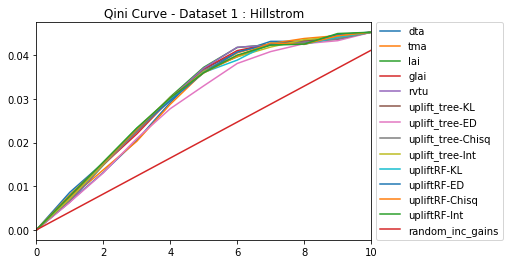

In [23]:
hillstrom_resultset = qini_resultset
result_draw = pd.DataFrame({})
print(result_draw)
for model, results in hillstrom_resultset.items():
    print(model)
    fold1 = results[0]
    fold2 = results[1]
    fold3 = results[2]
    fold4 = results[3]
    fold5 = results[4]
    
    q_mean = round((np.mean(pd.DataFrame([fold1.inc_gains, fold2.inc_gains, fold3.inc_gains, fold4.inc_gains, fold5.inc_gains]))), 6)
    result_draw[model] = q_mean
print(result_draw.iloc[[10]])
## Random incremental gains
overall_inc_gain = np.max(result_draw.iloc[[10]].values)
print(overall_inc_gain)
random_inc_gains = [i*overall_inc_gain / len(result_draw) for i in range(len(result_draw))]
result_draw['random_inc_gains'] = random_inc_gains
result_draw.plot()
plt.title("Qini Curve - Dataset 1 : Hillstrom")
# plt.xlabel("Amount of Variables")
# plt.ylabel("Qini Value")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

dta
tma
lai
glai
rvtu
uplift_tree-KL
uplift_tree-ED
uplift_tree-Chisq
uplift_tree-Int
upliftRF-KL
upliftRF-ED
upliftRF-Chisq
upliftRF-Int
      fold_1    fold_2    fold_3    fold_4    fold_5
0   0.000000  0.000000  0.000000  0.000000  0.000000
1   0.005515  0.009998  0.004736  0.006046  0.005324
2   0.013467  0.018336  0.012168  0.010146  0.011173
3   0.023308  0.023964  0.019590  0.018852  0.018821
4   0.028075  0.031396  0.027671  0.025220  0.026330
5   0.030685  0.039450  0.036240  0.030472  0.028000
6   0.032966  0.043392  0.040961  0.036207  0.036892
7   0.035995  0.045744  0.044397  0.038459  0.039459
8   0.039678  0.045373  0.046819  0.038605  0.042625
9   0.042155  0.043379  0.045689  0.041990  0.043283
10  0.045185  0.045185  0.045394  0.045196  0.045206
0.04539426541583816


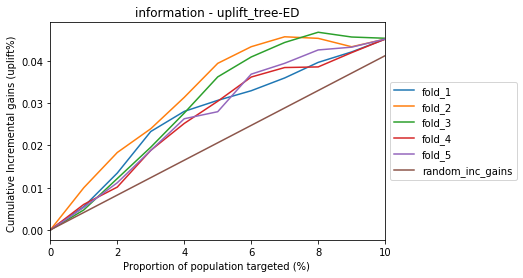

In [29]:
fold_draw = pd.DataFrame({})
for model, results in hillstrom_resultset.items():
    print(model)
    fold_draw[model] = [np.max(results[0].qini), np.max(results[1].qini), np.max(results[2].qini), np.max(results[3].qini), np.max(results[4].qini)]

# best = criteo_resultset[upliftRF-ED]
# worst = criteo_resultset[uplift_tree-ED]
# print(fold_draw.sum())
fold_draw_info = pd.DataFrame({})
for idx, fold in enumerate(hillstrom_resultset['uplift_tree-ED']):
    fold_draw_info['fold_' + str(idx+1)] = fold.inc_gains

print(fold_draw_info)    
## Random incremental gains
overall_inc_gain = np.max(fold_draw_info.iloc[[10]].values)
print(overall_inc_gain)
random_inc_gains = [i*overall_inc_gain / len(fold_draw_info) for i in range(len(fold_draw_info))]
fold_draw_info['random_inc_gains'] = random_inc_gains
fold_draw_info.plot()
plt.title("information - uplift_tree-ED")
plt.xlabel("Proportion of population targeted (%) ")
plt.ylabel("Cumulative Incremental gains (uplift%) ")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

         dta       tma  ...  upliftRF-Int  random_inc_gains
0   0.000000  0.000000  ...      0.000000          0.000000
1   0.006499  0.007201  ...      0.007759          0.004112
2   0.013144  0.013744  ...      0.015543          0.008224
3   0.020512  0.020277  ...      0.023307          0.012336
4   0.029158  0.028750  ...      0.030223          0.016448
5   0.036753  0.036131  ...      0.035972          0.020560
6   0.040596  0.040520  ...      0.039998          0.024673
7   0.043146  0.042629  ...      0.042270          0.028785
8   0.043143  0.043802  ...      0.042513          0.032897
9   0.044652  0.044465  ...      0.044939          0.037009
10  0.045233  0.045233  ...      0.045233          0.041121

[11 rows x 14 columns]
dta
tma
lai
glai
rvtu
uplift_tree-KL
uplift_tree-ED
uplift_tree-Chisq
uplift_tree-Int
upliftRF-KL
upliftRF-ED
upliftRF-Chisq
upliftRF-Int
0.04518452313178267


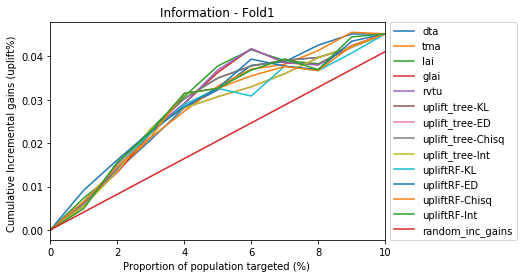

In [31]:
fold1_df = pd.DataFrame({})
fold3_df = pd.DataFrame({})
print(result_draw)
for model, results in hillstrom_resultset.items():
    print(model)
    fold1 = results[0]
#     fold2 = results[1]
    fold3 = results[2]
#     fold4 = results[3]
#     fold5 = results[4]
    
#     q_mean = round((np.mean(pd.DataFrame([fold1.inc_gains, fold2.inc_gains, fold3.inc_gains, fold4.inc_gains, fold5.inc_gains]))), 6)
    fold1_df[model] = fold1.inc_gains
    fold3_df[model] = fold3.inc_gains
# print(result_draw.iloc[[10]])
## Random incremental gains
overall_inc_gain = np.min(fold1_df.iloc[[10]].values)
print(overall_inc_gain)
random_inc_gains = [i*overall_inc_gain / len(result_draw) for i in range(len(result_draw))]
fold1_df['random_inc_gains'] = random_inc_gains
fold1_df.plot()
plt.title("Information - Fold1")
plt.xlabel("Proportion of population targeted (%) ")
plt.ylabel("Cumulative Incremental gains (uplift%) ")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [32]:
criteo_resultset

NameError: ignored

In [0]:
import sys
import numpy as np
import random
import math

import warnings
warnings.filterwarnings("ignore")

class Node(object):
    def __init__(self, attribute, threshold):
        self.attr = attribute
        self.thres = threshold
        self.left = None
        self.right = None
        self.leaf = False
        self.predict = None, None


def info_gain(df, attribute, predict_attr, treatment_attr,
              method, min_bucket_t0, min_bucket_t1):
    """
    Select the information gain and threshold of the attribute to split
    The threshold chosen splits the test data such that information gain is maximized
    
    Return a pandas.DataFrame
        columns: 'thres' (threshold) and 'info_gain' (information gain)
    """
    num_total = df.shape[0]
    tmp = pd.DataFrame({
        'thres': df[attribute],
        'Y': df[predict_attr],
        'T': df[treatment_attr]
    })
    tmp.sort_values(['thres'], inplace=True)

    tmp['n_t1_L'] = (tmp['T']).cumsum()
    tmp['n_t0_L'] = (tmp['T'] == 0).cumsum()
    tmp['n_t1_R'] = sum(tmp['T']) - (tmp['T']).cumsum()
    tmp['n_t0_R'] = sum(tmp['T'] == 0) - (tmp['T'] == 0).cumsum()
    tmp['n_y_t1_L'] = (tmp['T'] & tmp['Y']).cumsum()
    tmp['n_y_t0_L'] = ((tmp['T'] == 0) & tmp['Y']).cumsum()
    tmp['n_y_t1_R'] = sum(tmp['T'] & tmp['Y']) - (tmp['T'] & tmp['Y']).cumsum()
    tmp['n_y_t0_R'] = sum((tmp['T'] == 0) & tmp['Y']) - ((tmp['T'] == 0) & tmp['Y']).cumsum()
        
    # min bucket condition
    #   Check the size of treatment & control group in left & right child
    tmp['min_bucket_ok'] = ((tmp['n_t1_L'] >= min_bucket_t1) & 
                            (tmp['n_t0_L'] >= min_bucket_t0) &
                            (tmp['n_t1_R'] >= min_bucket_t1) &
                            (tmp['n_t0_R'] >= min_bucket_t0))
    
    if sum(tmp['min_bucket_ok']) > 0:
        num_total = df.shape[0]
        tr, tn, cr, cn = num_class(df, predict_attr, treatment_attr)
        n_t1 = tr + tn
        n_t0 = cr + cn
        pr_t1 = (tr + tn) / (num_total)
        # r_t0 = (tr + cr) / (num_total)
        pr_t0 = 1 - pr_t1
        pr_y1_t1 = tr / (tr + tn)
        pr_y1_t0 = cr / (cr + cn)

        # Randomized assignment implies pr_l_t1 = pr_l_t0 for all possible splits
        pr_l_t1 = (tmp['n_t1_L']) / (n_t1)
        pr_l_t0 = (tmp['n_t0_L']) / (n_t0)
        pr_l = pr_l_t1 * pr_t1 + pr_l_t0 * pr_t0
        pr_r = 1 - pr_l

        # Add Laplace correction to probablities
        pr_y1_l_t1 = (tmp['n_y_t1_L']) / (tmp['n_t1_L'])
        pr_y1_l_t0 = (tmp['n_y_t0_L']) / (tmp['n_t0_L'])
        pr_y1_r_t1 = (tmp['n_y_t1_R']) / (tmp['n_t1_R'])
        pr_y1_r_t0 = (tmp['n_y_t0_R']) / (tmp['n_t0_R'])

        # Number of treatment/control observations at left and right child nodes
        n_t1_L = tmp['n_t1_L']
        n_t0_L = tmp['n_t0_L']
        n_t1_R = tmp['n_t1_R']
        n_t0_R = tmp['n_t0_R']

        if method.lower() == 'ed':
            tmp['info_gain'] = eucli_dist(tmp,
                                          pr_y1_t1,
                                          pr_y1_t0,
                                          pr_l,
                                          pr_r,
                                          pr_y1_l_t1,
                                          pr_y1_l_t0,
                                          pr_y1_r_t1,
                                          pr_y1_r_t0,
                                          pr_t1,
                                          pr_t0,
                                          pr_l_t1,
                                          pr_l_t0)
        elif method.lower() == 'kl':
            tmp['info_gain'] = kl_divergence(tmp,
                                            pr_y1_t1,
                                            pr_y1_t0,
                                            pr_l,
                                            pr_r,
                                            pr_y1_l_t1,
                                            pr_y1_l_t0,
                                            pr_y1_r_t1,
                                            pr_y1_r_t0,
                                            pr_t1,
                                            pr_t0,
                                            pr_l_t1,
                                            pr_l_t0)
        elif method.lower() == 'chisq':
            tmp['info_gain'] = chisq(tmp,
                                    pr_y1_t1,
                                    pr_y1_t0,
                                    pr_l,
                                    pr_r,
                                    pr_y1_l_t1,
                                    pr_y1_l_t0,
                                    pr_y1_r_t1,
                                    pr_y1_r_t0,
                                    pr_t1,
                                    pr_t0,
                                    pr_l_t1,
                                    pr_l_t0)
        elif method.lower() == 'int':
            tmp['info_gain'] = interaction_split(tmp,
                                                pr_y1_t1,
                                                pr_y1_t0,
                                                pr_l,
                                                pr_r,
                                                pr_y1_l_t1,
                                                pr_y1_l_t0,
                                                pr_y1_r_t1,
                                                pr_y1_r_t0,
                                                pr_t1,
                                                pr_t0,
                                                pr_l_t1,
                                                pr_l_t0,
                                                n_t1_L,
                                                n_t0_L,
                                                n_t1_R,
                                                n_t0_R)
        else:
            raise NotImplementedError
    
    # We will select one rows per one distinct candidate
    tmp['dups'] = tmp['thres'].duplicated(keep='last')
    tmp['thres_ok'] = (tmp['min_bucket_ok'] & (tmp['dups'] == False))
    tmp.dropna(inplace=True)
    if sum(tmp['thres_ok']) < 1:
        return None

    tmp = tmp[tmp['thres_ok']]

    return tmp[['thres', 'info_gain']]
    


def num_class(df, predict_attr, treatment_attr):
    """
    Returns the number of Responders and Non-responders in Treatment and Control group
    """
    tr = df[(df[predict_attr] == 1) & (df[treatment_attr] == 1)]  # Responders in Treatment group
    tn = df[(df[predict_attr] == 0) & (df[treatment_attr] == 1)]  # Non-responders in Treatment group
    cr = df[(df[predict_attr] == 1) & (df[treatment_attr] == 0)]  # Responders in Control group
    cn = df[(df[predict_attr] == 0) & (df[treatment_attr] == 0)]  # Non-responders in Control group
    return tr.shape[0], tn.shape[0], cr.shape[0], cn.shape[0]


def choose_attr(df, attributes, predict_attr, treatment_attr,
                method, min_bucket_t0, min_bucket_t1):
    """
    Chooses the attribute and its threshold with the highest info gain
    from the set of attributes
    """
    max_info_gain = 0
    best_attr = None
    threshold = None
    # Test each attribute (note attributes maybe be chosen more than once)
    for attr in attributes:
        df_ig = info_gain(df, attr, predict_attr, treatment_attr,
                          method, min_bucket_t0, min_bucket_t1)
        if df_ig is None:
            continue

        # Get the possible indices of maximum info gain
        ig = max(df_ig['info_gain'])
        idx_ig = df_ig.index[df_ig['info_gain']==ig]
        # Break ties randomly
        idx_ig = random.choice(idx_ig)
        # Get information gain & threshold of that
        thres = df_ig['thres'][idx_ig]

        if ig > max_info_gain:
            max_info_gain = ig
            best_attr = attr
            threshold = thres
    return best_attr, threshold


def build_tree(df, cols, predict_attr='Y', treatment_attr='T',
               method='ED', depth=1, max_depth=float('INF'),
               min_split=2000, min_bucket_t0=None, min_bucket_t1=None,
               mtry=None, random_seed=3126):
    """
    Builds the Decision Tree based on training data, attributes to train on,
    and a prediction attribute
    """
    if depth == 1:
        np.random.seed(random_seed)
    
    if mtry is None:
        mtry = math.floor(math.sqrt(len(cols)))
    if min_bucket_t0 is None:
        min_bucket_t0 = round(min_split/4)
    if min_bucket_t1 is None:
        min_bucket_t1 = round(min_split/4)
    
    # Get the number of positive and negative examples in the training data
    tr, tn, cr, cn = num_class(df, predict_attr, treatment_attr)
    r_y1_ct1 = tr / (tr + tn)
    r_y1_ct0 = cr / (cr + cn)

    # Check varialbes have less than 2 levels at the current node
    # If not, exclude them as candidates for mtry selection
    # To split the node, sum(ok_vars) should be equal or larger than self.mtry
    ok_vars = []
    for col in cols:
        ok_vars.append(len(set(df[col])) > 1)

    # Whether we have to split this node
    #   1. min split condition: Both the sizes of treatment and control group 
    #     of an internal node should be larger than 'min_split'
    #   2. max depth condition: The depth of tree is 'max_depth'
    #   3. min_bucket condition: The number of treatment/control group of a
    #     node should be larger than 'min_bucket_t0'/'min_bucket_t1'
    #   4. Expected return should be larger than 0 and smaller than 1
    #     (for KL-divergence & Chisq splitting criteria)
    split_cond = tr + tn > min_split and cr + cn > min_split \
            and 0 < r_y1_ct1 < 1 and 0 < r_y1_ct0 < 1 \
            and depth < max_depth and sum(ok_vars) >= mtry
    
    best_attr, threshold = None, None
    if split_cond:
        # Sample columns
        ok_cols = [col for col in cols if len(set(df[col])) > 1]
        ok_cols = np.random.choice(ok_cols, mtry, replace=False)
        # Determine attribute and its threshold value with the highest
        # information gain
        best_attr, threshold = choose_attr(df, ok_cols, predict_attr, treatment_attr,
                                           method, min_bucket_t0, min_bucket_t1)
    if best_attr is None:
        # Create a leaf node indicating it's prediction
        leaf = Node(None,None)
        leaf.leaf = True
        leaf.predict = (tr / (tr + tn), cr / (cr + cn))
        return leaf
    else:
        # Create internal tree node based on attribute and it's threshold
        sub_1 = df[df[best_attr] <= threshold]
        sub_2 = df[df[best_attr] > threshold]
        sub1_tr, sub1_tn, sub1_cr, sub1_cn = num_class(sub_1, predict_attr, treatment_attr)
        sub2_tr, sub2_tn, sub2_cr, sub2_cn = num_class(sub_2, predict_attr, treatment_attr)
        tree = Node(best_attr, threshold)
        # Recursively build left and right subtree
        tree.left = build_tree(sub_1, cols, predict_attr, treatment_attr,
                               method=method, depth=depth+1, max_depth=max_depth,
                               min_split=min_split, min_bucket_t0=min_bucket_t0, 
                               min_bucket_t1=min_bucket_t1, mtry=mtry)
        tree.right = build_tree(sub_2, cols, predict_attr, treatment_attr,
                               method=method, depth=depth+1, max_depth=max_depth,
                               min_split=min_split, min_bucket_t0=min_bucket_t0, 
                               min_bucket_t1=min_bucket_t1, mtry=mtry)
        return tree


def predict(node, row_df):
    """
    Given a instance of a training data, make a prediction of an observation (row)
    based on the Decision Tree
    Assumes all data has been cleaned (i.e. no NULL data)
    """
    # If we are at a leaf node, return the prediction of the leaf node
    if node.leaf:
        return node.predict
    # Traverse left or right subtree based on instance's data
    if row_df[node.attr] <= node.thres:
        return predict(node.left, row_df)
    elif row_df[node.attr] > node.thres:
        return predict(node.right, row_df)


def test_predictions(root, df):
    """
    Given a set of data, make a prediction for each instance using the Decision Tree
    """
    pred_treat = []
    pred_control = []
    for index,row in df.iterrows():
        return_treated, return_control = predict(root, row)
        pred_treat.append(return_treated)
        pred_control.append(return_control)
    pred_df = pd.DataFrame({
        "pr_y1_t1": pred_treat,
        "pr_y1_t0": pred_control,
    })
    return pred_df




In [0]:
def eucli_dist(small_df,
               pr_y1_ct1,
               pr_y1_ct0,
               pr_l,
               pr_r,
               pr_y1_l_ct1,
               pr_y1_l_ct0,
               pr_y1_r_ct1,
               pr_y1_r_ct0,
               pr_ct1,
               pr_ct0,
               pr_l_ct1,
               pr_l_ct0):
    # Euclidean gain
    ed_node = (pr_y1_ct1 - pr_y1_ct0) ** 2 + ((1 - pr_y1_ct1) - (1 - pr_y1_ct0)) ** 2
    ed_l = (pr_y1_l_ct1 - pr_y1_l_ct0) ** 2 + ((1 - pr_y1_l_ct1) - (1 - pr_y1_l_ct0)) ** 2
    ed_r = (pr_y1_r_ct1 - pr_y1_r_ct0) ** 2 + ((1 - pr_y1_r_ct1) - (1 - pr_y1_r_ct0)) ** 2
    ed_lr = pr_l * ed_l + pr_r * ed_r
    ed_gain = ed_lr - ed_node

    # Euclidean Normalization factor
    gini_ct = 2 * pr_ct1 * (1 - pr_ct1)
    ed_ct = (pr_l_ct1 - pr_l_ct0) ** 2 + ((1 - pr_l_ct1) - (1 - pr_l_ct0)) ** 2
    gini_ct1 = 2 * pr_l_ct1 * (1 - pr_l_ct1)
    gini_ct0 = 2 * pr_l_ct0 * (1 - pr_l_ct0)
    ed_norm = gini_ct * ed_ct + gini_ct1 * pr_ct1 + gini_ct0 * pr_ct0 + 0.5
    
    # Output
    info_gain_t = ed_gain / ed_norm

    return info_gain_t


def kl_divergence(small_df,
                  pr_y1_ct1,
                  pr_y1_ct0,
                  pr_l,
                  pr_r,
                  pr_y1_l_ct1,
                  pr_y1_l_ct0,
                  pr_y1_r_ct1,
                  pr_y1_r_ct0,
                  pr_ct1,
                  pr_ct0,
                  pr_l_ct1,
                  pr_l_ct0):
    # KL Gain
    kl_node = pr_y1_ct1 * np.log2(pr_y1_ct1/pr_y1_ct0) + \
             (1 - pr_y1_ct1) * np.log2((1 - pr_y1_ct1) / (1 - pr_y1_ct0))
    kl_l = pr_y1_l_ct1 * np.log2(pr_y1_l_ct1 / pr_y1_l_ct0) + \
          (1 - pr_y1_l_ct1) * np.log2((1 - pr_y1_l_ct1) / (1 - pr_y1_l_ct0))
    kl_r = pr_y1_r_ct1 * np.log2(pr_y1_r_ct1 / pr_y1_r_ct0) + \
          (1 - pr_y1_r_ct1) * np.log2((1 - pr_y1_r_ct1) / (1 - pr_y1_r_ct0))
    kl_lr = pr_l * kl_l + pr_r * kl_r
    kl_gain = kl_lr - kl_node

    # KL Normalization factor
    ent_ct = -(pr_ct1 * np.log2(pr_ct1) + pr_ct0 * np.log2(pr_ct0))
    kl_ct = pr_l_ct1 * np.log2(pr_l_ct1 / pr_l_ct0) + \
           (1 - pr_l_ct1) * np.log2 ((1 - pr_l_ct1) / (1 - pr_l_ct0))
    ent_ct1 = -(pr_l_ct1 * np.log2(pr_l_ct1) + (1 - pr_l_ct1) * np.log2((1 - pr_l_ct1)))
    ent_ct0 = -(pr_l_ct0 * np.log2(pr_l_ct0) + (1 - pr_l_ct0) * np.log2((1 - pr_l_ct0)))

    norm = kl_ct * ent_ct + ent_ct1 * pr_ct1 + ent_ct0 * pr_ct0 + 0.5

    # Output
    info_gain_t = kl_gain / norm

    return info_gain_t


def chisq(small_df,
          pr_y1_ct1,
          pr_y1_ct0,
          pr_l,
          pr_r,
          pr_y1_l_ct1,
          pr_y1_l_ct0,
          pr_y1_r_ct1,
          pr_y1_r_ct0,
          pr_ct1,
          pr_ct0,
          pr_l_ct1,
          pr_l_ct0):
    # Chi-squared gain
    chisq_node = ((pr_y1_ct1 - pr_y1_ct0) ** 2) / pr_y1_ct0 + \
                (((1 - pr_y1_ct1) - (1 - pr_y1_ct0)) ** 2) / (1 - pr_y1_ct0) 
    chisq_l = ((pr_y1_l_ct1 - pr_y1_l_ct0) ** 2) / pr_y1_l_ct0 + \
             (((1 - pr_y1_l_ct1) - (1 - pr_y1_l_ct0)) ** 2) / (1 - pr_y1_l_ct0)
    chisq_r = ((pr_y1_r_ct1 - pr_y1_r_ct0) ** 2) / pr_y1_r_ct0 + \
             (((1 - pr_y1_r_ct1) - (1 - pr_y1_r_ct0)) ** 2) / (1 - pr_y1_r_ct0)
    chisq_lr = pr_l * chisq_l + pr_r * chisq_r
    chisq_gain = chisq_lr - chisq_node

    # Chi-squared Normalization factor
    gini_ct = 2 * pr_ct1 * (1 - pr_ct1) 
    chisq_ct = ((pr_l_ct1 - pr_l_ct0) ** 2) / pr_l_ct0 + \
              (((1 - pr_l_ct1) - (1 - pr_l_ct0)) ** 2) / (1 - pr_l_ct0)
    gini_ct1 = 2 * pr_l_ct1 * (1 - pr_l_ct1)
    gini_ct0 = 2 * pr_l_ct0 * (1 - pr_l_ct0)
    chisq_norm = gini_ct * chisq_ct + gini_ct1 * pr_ct1  + gini_ct0 * pr_ct0 + 0.5
     
    # Output
    info_gain_t = chisq_gain / chisq_norm

    return info_gain_t


def interaction_split(small_df,
                      pr_y1_ct1,
                      pr_y1_ct0,
                      pr_l,
                      pr_r,
                      pr_y1_l_ct1,
                      pr_y1_l_ct0,
                      pr_y1_r_ct1,
                      pr_y1_r_ct0,
                      pr_ct1,
                      pr_ct0,
                      pr_l_ct1,
                      pr_l_ct0,
                      cs_ct1,
                      cs_ct0,
                      ncs_ct1,
                      ncs_ct0):
    # Compute elements for split formula
    C44 = 1/cs_ct1 + 1/cs_ct0 + 1/ncs_ct1 + 1/ncs_ct0

    UR = pr_y1_r_ct1 - pr_y1_r_ct0
    UL = pr_y1_l_ct1 - pr_y1_l_ct0

    SSE = cs_ct1 * pr_y1_l_ct1 * (1 - pr_y1_l_ct1) + \
         ncs_ct1 * pr_y1_r_ct1 * (1 - pr_y1_r_ct1) + \
         cs_ct0 * pr_y1_l_ct0 * (1 - pr_y1_l_ct0)  + \
         ncs_ct0 * pr_y1_r_ct0 * (1 - pr_y1_r_ct0)
         
    n_node = len(small_df)       

    # Output: Interaction split
    info_gain_t = ((n_node - 4) * (UR - UL)**2) / (C44 * SSE)

    return info_gain_t


In [0]:
def uplift_tree(x, y, t, **kwargs):
    predict_attr = kwargs.get('predict_attr', 'Y')
    treatment_attr = kwargs.get('treatment_attr', 'T')
    
    df = x.copy()
    df[predict_attr] = y
    df[treatment_attr] = t
    
    kwargs['predict_attr'] = predict_attr
    kwargs['treatment_attr'] = treatment_attr
    root = build_tree(df, x.columns, **kwargs)
    
    return root


def predict_tree(root, newdata, **kwargs):
    return test_predictions(root, newdata)


In [0]:
def upliftRF(x, y, t, ntree=10, bagging_fraction=0.6, random_seed=3126, **kwargs):
    predict_attr = kwargs.get('predict_attr', 'Y')
    treatment_attr = kwargs.get('treatment_attr', 'T')
    
    df = x.copy()
    df[predict_attr] = y
    df[treatment_attr] = t
    
    kwargs['predict_attr'] = predict_attr
    kwargs['treatment_attr'] = treatment_attr

    np.random.seed(random_seed)
    random_seeds = [np.random.randint(10000) for _ in range(ntree)]
    trees = []
    for i in range(ntree):
        bagged_df = df.sample(frac=bagging_fraction, random_state=random_seeds[i])
        trees.append(build_tree(bagged_df, x.columns, random_seed=random_seeds[i], **kwargs))
    
    return trees


def predict_upliftRF(obj, newdata, **kwargs):
    pred_trees = []
    for tree in obj:
        pred_trees.append(test_predictions(tree, newdata))

    pred_df = pd.DataFrame({
        "pr_y1_t1": sum([x['pr_y1_t1'] for x in pred_trees])/len(pred_trees),
        "pr_y1_t0": sum([x['pr_y1_t0'] for x in pred_trees])/len(pred_trees),
    })
    return pred_df

In [0]:
from sklearn.ensemble import GradientBoostingClassifier


def z_assign(y, t):
    """ Define transformed response variable z
    if (treated and response) or (not treated and not response), return 1
    else, return 0
    """
    if y == 1 and t == 1:
        return 1
    elif y == 0 and t == 1:
        return 0
    elif y == 1 and t == 0:
        return 0
    elif y == 0 and t == 0:
        return 1
    else:
        return None


def lai(x, y, t, method=GradientBoostingClassifier, **kwargs):
    """Training a model according to the "Lai's Approach" 
    The default model is Gradient Boosting Machine (gbm)

    Source: "Influential Marketing" (Lai, 2006) and "Mining Truly Responsive
            Customers Using True Lift Overview" (Kane, 2014)

    Args:
        x: A data frame of predictors.
        y: A binary response (numeric) vector.
        t: A binary response (numeric) representing the treatment assignment
            (coded as 0/1).
        method: A sklearn model specifying which classification or regression
            model to use. This should be a method that can handle a 
            multinominal class variable.

    Return:
        A sklearn model.
    """
    df = pd.DataFrame({'y': y.copy()})
    df['t'] = t
    z = df.apply(lambda row: z_assign(row['y'], row['t']), axis=1)
    
    model = method(**kwargs).fit(x, z)
    
    return model


def predict_lai(obj, newdata, y, t, **kwargs):
    """Predictions according to the "Lai's Approach" 
    
    Source: "Influential Marketing" (Lai, 2006) and "Mining Truly Responsive
            Customers Using True Lift Overview" (Kane, 2014)

    Args:
        obj: A sklearn model.
        newdata: A data frame containing the values at which predictions
            are required.
    
    Return:
        dataframe: A dataframe with predictions for when the instances are
            treated and for when they are not treated.
    """
 
    pred = obj.predict_proba(newdata)    # list of [False, True]

    res = pd.DataFrame({
        "pr_y1_t1": [row[1] for row in pred],
        "pr_y1_t0": [row[0] for row in pred],
    })
    return res


In [0]:
from sklearn.ensemble import GradientBoostingClassifier


def glai(x, y, t, method=GradientBoostingClassifier, **kwargs):
    """Training a model according to the "Lai's Approach" 
    The default model is Gradient Boosting Machine (gbm)

    Source: "Influential Marketing" (Lai, 2006) and "Mining Truly Responsive
            Customers Using True Lift Overview" (Kane, 2014)

    Args:
        x: A data frame of predictors.
        y: A binary response (numeric) vector.
        t: A binary response (numeric) representing the treatment assignment
            (coded as 0/1).
        method: A sklearn model specifying which classification or regression
            model to use. This should be a method that can handle a 
            multinominal class variable.

    Return:
        A sklearn model.
    """
    df = pd.DataFrame({'y': y.copy()})
    df['t'] = t
    ty = df.apply(lambda row: ty_assign(row['y'], row['t']), axis=1)
    
    model = method(**kwargs).fit(x, ty)
    
    return model


def predict_glai(obj, newdata, y, t, **kwargs):
    """Predictions according to the "Lai's Approach" 
    
    Source: "Influential Marketing" (Lai, 2006) and "Mining Truly Responsive
            Customers Using True Lift Overview" (Kane, 2014)

    Args:
        obj: A sklearn model.
        newdata: A data frame containing the values at which predictions
            are required.
    
    Return:
        dataframe: A dataframe with predictions for when the instances are
            treated and for when they are not treated.
    """
    prob_T = sum(t) / len(t)
    prob_C = 1 - prob_T
    
    pred = obj.predict_proba(newdata)    # list of [CN, CR, TN, TR]

    res = pd.DataFrame({
        "pr_y1_t1": [row[3]/prob_T + row[0]/prob_C for row in pred],   # TR/T + CN/C
        "pr_y1_t0": [row[2]/prob_T + row[1]/prob_C for row in pred],   # TN/T + CR/C
    })
    return res


In [0]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


def z_assign(y, t):
    """ Define transformed response variable z
    if (treated and response) or (not treated and not response), return 1
    else, return 0
    """
    if y == 1 and t == 1:
        return 1
    elif y == 0 and t == 1:
        return 0
    elif y == 1 and t == 0:
        return 0
    elif y == 0 and t == 0:
        return 1
    else:
        return None




def rvtu(x, y, t, method=LogisticRegression, **kwargs):
    """Transforming the data according to the "Jaskowski's Approach"
    Sometimes, it called Response Variable Transformation for Uplift (RVTU)

    Source: "Uplift modeling for clinical trial data" (Jaskowski, 2006)
    """

    ### Combine x, y, and ct
    df = x.copy()
    df['y'] = y
    df['ct'] = t
    df['z'] = df.apply(lambda row: z_assign(row['y'], row['ct']), axis=1)
    mdl = method(**kwargs).fit(x, df['z'])
    
    return mdl


def predict_rvtu(obj, newdata, y, t, **kwargs):
    # df = pd.DataFrame({'y': y.copy()})
    # df['ct'] = ct
    # z = df.apply(lambda row: z_assign(row['y'], row['ct']), axis=1)

    if isinstance(obj, LinearRegression):
        pred = obj.predict(newdata)
    else:
        pred = obj.predict_proba(newdata)[:, 1]

    res = pd.DataFrame({
        "pr_y1_t1": [row for row in pred],
        "pr_y1_t0": [1-row for row in pred],
    })
    return res


In [0]:
from sklearn.linear_model import LogisticRegression
import pandas as pd


def dta(x, y, t, method=LogisticRegression, **kwargs):
    """Training a model according to the "Dummy Treatment Approach" 
    The default model is General Linear Model (GLM)

    Source: "The True Lift Model" (Lo, 2002)

    Args:
        x: A data frame of predictors.
        y: A binary response (numeric) vector.
        t: A binary response (numeric) representing the treatment assignment
            (coded as 0/1).
        method: A sklearn model specifying which classification or regression
            model to use. This should be a method that can handle a 
            multinominal class variable.

    Return:
        A sklearn model.
    """
    # Create interaction variables
    # Building our dataframe with the interaction variables
    df = x.copy()
    for colname in x.columns:
        df["Int_" + colname] = x[colname] * t
    df['treated'] = t

    # Fit a model
    model = method(**kwargs).fit(df, y)

    return model


def predict_dta(obj, newdata, y_name='y', t_name='treated', **kwargs):
    """Predictions according to the "Dummy Treatment Approach" 
    
    For each instance in newdata two predictions are made:
    1) What is the probability of a person responding when treated?
    2) What is the probability of a person responding when not treated
      (i.e. part of control group)?

    Source: "The True Lift Model" (Lo, 2002)

    Args:
        obj: A sklearn model.
        newdata: A data frame containing the values at which predictions
            are required.
    
    Return:
        dataframe: A dataframe with predictions for when the instances are
            treated and for when they are not treated.
    """
    predictors = [c for c in newdata.columns if c not in (y_name, t_name)]

    df_treat = newdata.copy()
    df_control = newdata.copy()
    for colname in predictors:
        df_treat["Int_" + colname] = df_treat[colname] * 1
        df_control["Int_" + colname] = df_control[colname] * 0
    df_treat['treated'] = 1
    df_control['treated'] = 0

    # print(obj.coef_, obj.intercept_)
    if isinstance(obj, LinearRegression):
        pred_treat = obj.predict(df_treat)
        pred_control = obj.predict(df_control)
    else:
#         pred = obj.predict_proba(newdata)[:, 1]
        pred_treat = obj.predict_proba(df_treat)[:, 1]
        pred_control = obj.predict_proba(df_control)[:, 1]

    pred_df = pd.DataFrame({
        "pr_y1_t1": pred_treat,
        "pr_y1_t0": pred_control,
    })
    return pred_df

